# Transverse field ising model
The transverse field ising model is given by the Hamiltonian
$$H = - J \sum_{<i,j>} Z_i Z_j + g \sum_j X_j$$

We will implement it in two ways and compare the results. This also serves as a test of whether the documentation is correct (See AKLT states)

In [54]:
import numpy as np
from tenpy.networks.mps import MPS
from tenpy.networks.site import SpinSite, kron
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel
from tenpy.algorithms import dmrg
from tenpy.tools.params import asConfig
import matplotlib.pyplot as plt

## Implementation with `CouplingModel`
The first implementation is done using `CouplingModel`

In [55]:
class TFIsing_Coupling(MPOModel, CouplingModel):
    def __init__(self,model_params):
        model_params = asConfig(model_params,"Transverse field Ising") # Convert the dictionary into Config
        L = model_params.get('L',2)
        J = model_params.get('J',1)
        g = model_params.get('g',1)
        S = model_params.get('S',1/2)
        
        self.J, self.g, self.L = J, g, L
        bc_MPS = model_params.get('bc_MPS','finite')
        sort_charge = model_params.get('sort_charge',True)

        site = SpinSite(S=S,conserve='None') # No conserved charge
        bc = 'open' if bc_MPS == 'finite' else 'periodic'

        self.lat = Chain(L,site,bc=bc,bc_MPS=bc_MPS) # Initialize a spin chain

        CouplingModel.__init__(self,self.lat) # Initialize coupling model
        # Remark: u1 and u2 in add coupling actually refers to the elements within a unit cell
        # since our unit cell only has one spin site they are always 0
        self.add_coupling(-J,0,'Sz',0,'Sz',1) # On-site NN coupling
        self.add_onsite(g,0,'Sx') # Transverse field

        MPOModel.__init__(self,self.lat,self.calc_H_MPO()) # Initialize MPO model with MPO Hamiltonian

In [56]:
# Code refactoring 
def run(model_class,model_params): 
    model = model_class(model_params)
    prod_state = ['up']*model.lat.N_sites
    psi = MPS.from_random_unitary_evolution(sites=model.lat.mps_sites(),chi=3,p_state=prod_state,bc=model.lat.bc_MPS)
    #psi = MPS.from_product_state(model.lat.mps_sites(),prod_state,bc=model.lat.bc_MPS)
    dmrg_params = {
        'mixer': None,  # setting this to True helps to escape local minima
        'max_E_err': 1.e-10,
        'trunc_params': {
            'chi_max': 100,
            'svd_min': 1.e-10
        },
        'combine': True
    }
    # I need to wavefunction so we need some trick here
    options = asConfig(dmrg_params,'DMRG')
    engine = dmrg.TwoSiteDMRGEngine(psi,model,options)
    E, gswf = engine.run()
    info = {
        'E': E,
        'psi':gswf,
        'shelve': engine.shelve,
        'bond_statistics': engine.update_stats,
        'sweep_statistics': engine.sweep_stats
    }
    return model, info

### Test cases 1: $J=0, L=10$
When $J=0$, the GS should be either all left or all right, depending on the sign of $g$. Regardless of the sign of $g$, the ground state energy will also be $E_{GS}=-s|g|N$, where $s$ is the on-site spin.
To test this, we will prepare two direct product states $|\rightarrow\rightarrow\cdots \rightarrow\rangle$ and $|\leftarrow\leftarrow\cdots\leftarrow\rangle$ and compute the overlap as $g$ goes from -ve to +ve

In [199]:
L = 10
gs = np.linspace(-1,1,20)
GS_Energy = []
up_x_overlap = []
dn_x_overlap = []
for g in gs:
    model, info = run(TFIsing_Coupling,dict(L=10,J=0,g=g,S=1/2))
    up_x = [np.array([1,1])/np.sqrt(2)]*L # A better way to do it is to initialize an array of 2S+1 then changes the first and last entry, but anyway
    dn_x = [np.array([1,-1])/np.sqrt(2)]*L
    up_x = MPS.from_product_state(model.lat.mps_sites(),up_x,bc=model.lat.bc_MPS)
    dn_x = MPS.from_product_state(model.lat.mps_sites(),dn_x,bc=model.lat.bc_MPS)
    GS_Energy.append(info['E'])
    up_x_overlap.append(np.abs(up_x.overlap(info['psi'])))
    dn_x_overlap.append(np.abs(dn_x.overlap(info['psi'])))
GS_Energy = np.array(GS_Energy)
up_x_overlap = np.array(up_x_overlap)
dn_x_overlap = np.array(dn_x_overlap)

In [200]:
plt.plot(gs,GS_Energy/(L/2),marker='o')
plt.xlabel('Field coupling g')
plt.ylabel('GS Energy $E_{GS}/ Ls$')

Text(0, 0.5, 'GS Energy $E_{GS}/ Ls$')

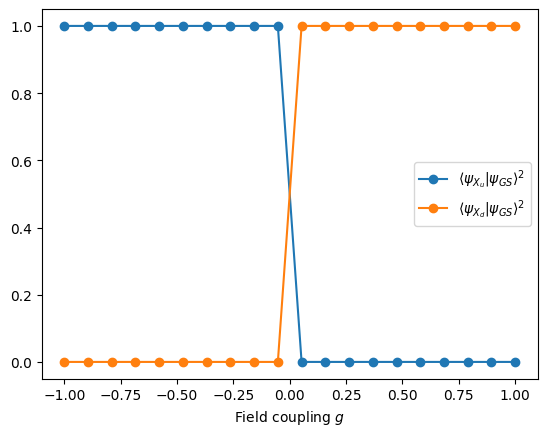

In [201]:
plt.plot(gs,up_x_overlap,label=r'$\langle \psi_{X_u}| \psi_{GS}\rangle^2$',marker='o')
plt.plot(gs,dn_x_overlap,label=r'$\langle \psi_{X_d}| \psi_{GS}\rangle^2$',marker='o')
plt.xlabel(r'Field coupling $g$')
plt.legend()

This make sense because when $g<0$ the energy is lower if you point up (in X direction), and vice versa

### Test case 2: Anti-ferromagnetic case ($L=10,g=0$)
When $g=0$ and $J$ varies the system will either fall into a feromagnetic or antifermomagnetic phase. To detect this, we can plot the magnetization as a function of spin-spin coupling $J$ 

To check the transition between ferromagnetic or anti-ferromagnetic phase, we compute the magnetisation. The total magnetization should be zero in anti-ferromagnetic phase, and non-zero in the ferromagnetic phase

To check the wavefunction overlap, we compute the projection onto the corresponding subspaces

In [202]:
L = 10
Js = np.repeat(np.linspace(-1,1,20),3)
GS_Energy_g0 = []
overlaps_out = {}
z_tot = [] 
for J in Js*2:
    model, info = run(TFIsing_Coupling,dict(L=10,J=J,g=0.05,S=1/2))
    ferro_up = MPS.from_product_state(model.lat.mps_sites(),['up']*L,bc=model.lat.bc_MPS)
    ferro_dn = MPS.from_product_state(model.lat.mps_sites(),['down']*L,bc=model.lat.bc_MPS)
    antif_ud = MPS.from_product_state(model.lat.mps_sites(),['up','down']*(L//2),bc=model.lat.bc_MPS)
    antif_du = MPS.from_product_state(model.lat.mps_sites(),['down','up']*(L//2),bc=model.lat.bc_MPS)
    ref_states = {'ferro_up':ferro_up, 'ferro_dn':ferro_dn, 'antif_ud':antif_ud, 'antif_du':antif_du}
    
    GS_Energy_g0.append(info['E'])
    z_tot.append(np.sum(info['psi'].expectation_value('Sz')))
    for key, psi in ref_states.items():
        if key not in overlaps_out:
            overlaps_out[key] = []
        overlaps_out[key].append(np.abs(psi.overlap(info['psi']))**2)
    #up_x_overlap.append(np.abs(up_x.overlap(info['psi'])))
    #dn_x_overlap.append(np.abs(dn_x.overlap(info['psi'])))
GS_Energy_g0 = np.array(GS_Energy_g0)
z_tot = np.array(z_tot)
for key, out in overlaps_out.items():
    overlaps_out[key] = np.array(overlaps_out[key])

final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=1.09e-02
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=6.38e-04
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=5.35e-04
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=5.45e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.83e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=4.01e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=6.66e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=4.77e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=6.81e-05
final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=5.75e-02


In [203]:
#plt.plot(Js,GS_Energy_g0)

In [206]:
plt.plot(Js,2*z_tot/L,marker='o',ls='None')
plt.ylabel(r'$\langle S_z\rangle/s$')
plt.xlabel(r'Spin-spin coupling $J$')

Text(0.5, 0, 'Spin-spin coupling $J$')

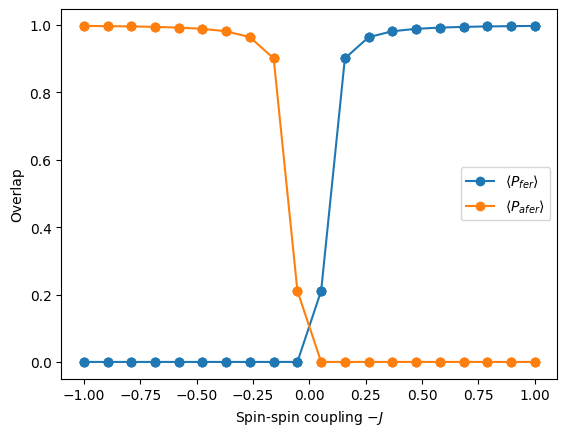

In [207]:
plt.plot(Js,overlaps_out['ferro_up']+overlaps_out['ferro_dn'],marker='o',label=r'$\langle P_{fer}\rangle$')
plt.plot(Js,overlaps_out['antif_ud']+overlaps_out['antif_du'],marker='o',label=r'$\langle P_{afer}\rangle$')
plt.xlabel(r'Spin-spin coupling $-J$')
plt.ylabel(r'Overlap')
plt.legend()

### Test case 3: $L=10$, $g=0.5$ 
We now consider the case when $g$ is non-zero. 

In [10]:
L = 10
Js = np.repeat(np.linspace(-1,1,20),3)
GS_Energy_g05 = []
#up_x_overlap = []
#dn_x_overlap = []
z_totg05 = [] 
for J in Js*2:
    model, info = run(TFIsing_Coupling,dict(L=10,J=J,g=0.2,S=1/2))
    #up_x = [np.array([1,1])/np.sqrt(2)]*L # A better way to do it is to initialize an array of 2S+1 then changes the first and last entry, but anyway
    #dn_x = [np.array([1,-1])/np.sqrt(2)]*L
    #up_x = MPS.from_product_state(model.lat.mps_sites(),up_x,bc=model.lat.bc_MPS)
    #dn_x = MPS.from_product_state(model.lat.mps_sites(),dn_x,bc=model.lat.bc_MPS)
    GS_Energy_g05.append(info['E'])
    z_totg05.append(np.sum(info['psi'].expectation_value('Sz')))
    #up_x_overlap.append(np.abs(up_x.overlap(info['psi'])))
    #dn_x_overlap.append(np.abs(dn_x.overlap(info['psi'])))
GS_Energy_g05 = np.array(GS_Energy_g05)
z_totg05 = np.array(z_totg05)
#up_x_overlap = np.array(up_x_overlap)
#dn_x_overlap = np.array(dn_x_overlap)

In [11]:
plt.plot(Js,2*z_totg05/L,marker='o',ls='None')
plt.ylabel(r'$\langle S_z\rangle/s$')
plt.xlabel(r'Spin-spin coupling $J$')

Text(0.5, 0, 'Spin-spin coupling $J$')

## Implementation using `NearestNeighborModel`

This is partly to understand why the AKLT code in the official defines their two body operators a little differently from what is mentioned in the documentation

In the documentation of `NearestNeighborModel`, it is said the Legs of each `H_bond[i]` has legs signature `['p0', 'p0*', 'p1', 'p1*']`, which is confusing.

In [208]:
class TFIsing_NN(MPOModel,NearestNeighborModel):
    def __init__(self, model_params):
        model_params = asConfig(model_params,"Transverse field ising")
        L = model_params.get('L',2)
        J = model_params.get('J',1)
        g = model_params.get('g',1)
        S = model_params.get('S',1/2)
        
        self.J, self.g, self.L = J, g, L
        bc_MPS = model_params.get('bc_MPS','finite')
        sort_charge = model_params.get('sort_charge',True)
        
        site = SpinSite(S=S,conserve='None') # No conserved charge
        bc = 'open' if bc_MPS == 'finite' else 'periodic'
        
        self.lat = Chain(L,site,bc=bc,bc_MPS=bc_MPS) # Initialize a spin chain

        # Following AKLT example
        leg_signature = ['p0', 'p1', 'p0*', 'p1*'] 
        # Following documentation
        #leg_signature = ['p0', 'p0*', 'p1', 'p1*']
        
        Sx, Sz, Id = site.Sx, site.Sz, site.Id
        Sz_dot_Sz = kron(Sz,Sz).split_legs().transpose(leg_signature)
        # Hacky way to get a one body term
        Sx_onsite = kron(Sx,Id).split_legs().transpose(leg_signature) 
        Sx_onsite_opp = kron(Id,Sx).split_legs().transpose(leg_signature) # More hacky stuff
    
        # Make a chain out of it
        H_bond = [-J*Sz_dot_Sz + g*Sx_onsite]*L
        if bc_MPS == 'finite':
            H_bond[0] = None # H[i] acts on site (i-1,i)
            H_bond[-1] += g*Sx_onsite_opp
            
        NearestNeighborModel.__init__(self,self.lat,H_bond)
        MPOModel.__init__(self,self.lat,self.calc_H_MPO_from_bond())
        
         

In [209]:
model_nn = TFIsing_NN(dict(L=10,J=0.1,g=1,S=1/2)) 
# Somehow NN model can't handle no spin-spin coupling..

In [210]:
L = 10
gs = np.linspace(-1,1,20)
GS_Energy = []
up_x_overlap = []
dn_x_overlap = []
for g in gs:
    model, info = run(TFIsing_NN,dict(L=10,J=0.1,g=g,S=1/2))
    up_x = [np.array([1,1])/np.sqrt(2)]*L # A better way to do it is to initialize an array of 2S+1 then changes the first and last entry, but anyway
    dn_x = [np.array([1,-1])/np.sqrt(2)]*L
    up_x = MPS.from_product_state(model.lat.mps_sites(),up_x,bc=model.lat.bc_MPS)
    dn_x = MPS.from_product_state(model.lat.mps_sites(),dn_x,bc=model.lat.bc_MPS)
    GS_Energy.append(info['E'])
    up_x_overlap.append(np.abs(up_x.overlap(info['psi'])))
    dn_x_overlap.append(np.abs(dn_x.overlap(info['psi'])))
GS_Energy = np.array(GS_Energy)
up_x_overlap = np.array(up_x_overlap)
dn_x_overlap = np.array(dn_x_overlap)

Apparently for finite MPS the algorithm will bring it back to canonical form https://tenpy.johannes-hauschild.de/viewtopic.php?t=192

In [211]:
plt.plot(gs,GS_Energy/(L/2),marker='o')
plt.xlabel('Field coupling g')
plt.ylabel('GS Energy $E_{GS}/ Ls$')

Text(0, 0.5, 'GS Energy $E_{GS}/ Ls$')

In [212]:
plt.plot(gs,up_x_overlap,label=r'$\langle \psi_{X_u}| \psi_{GS}\rangle^2$',marker='o') # Doesn't look too good to me, is it even normalized...
plt.plot(gs,dn_x_overlap,label=r'$\langle \psi_{X_d}| \psi_{GS}\rangle^2$',marker='o')
plt.xlabel(r'Field coupling $g$')
plt.legend()

In [213]:
kron(Sz,Sz).split_legs()

<npc.Array shape=(2, 2, 2, 2) labels=['p0', 'p1', 'p0*', 'p1*']>

In [214]:
L = 10
Js = np.repeat(np.linspace(-1,1,20),3)
GS_Energy_g0 = []
overlaps_out = {}
z_tot = [] 
for J in Js*2:
    model, info = run(TFIsing_NN,dict(L=10,J=J,g=0,S=1/2))
    ferro_up = MPS.from_product_state(model.lat.mps_sites(),['up']*L,bc=model.lat.bc_MPS)
    ferro_dn = MPS.from_product_state(model.lat.mps_sites(),['down']*L,bc=model.lat.bc_MPS)
    antif_ud = MPS.from_product_state(model.lat.mps_sites(),['up','down']*(L//2),bc=model.lat.bc_MPS)
    antif_du = MPS.from_product_state(model.lat.mps_sites(),['down','up']*(L//2),bc=model.lat.bc_MPS)
    ref_states = {'ferro_up':ferro_up, 'ferro_dn':ferro_dn, 'antif_ud':antif_ud, 'antif_du':antif_du}
    
    GS_Energy_g0.append(info['E'])
    z_tot.append(np.sum(info['psi'].expectation_value('Sz')))
    for key, psi in ref_states.items():
        if key not in overlaps_out:
            overlaps_out[key] = []
        overlaps_out[key].append(np.abs(psi.overlap(info['psi']))**2)
    #up_x_overlap.append(np.abs(up_x.overlap(info['psi'])))
    #dn_x_overlap.append(np.abs(dn_x.overlap(info['psi'])))
GS_Energy_g0 = np.array(GS_Energy_g0)
z_tot = np.array(z_tot)
for key, out in overlaps_out.items():
    overlaps_out[key] = np.array(overlaps_out[key])

In [215]:
plt.plot(Js,2*z_tot/L,marker='o',ls='None')
plt.ylabel(r'$\langle S_z\rangle/s$')
plt.xlabel(r'Spin-spin coupling $J$')

Text(0.5, 0, 'Spin-spin coupling $J$')

In [216]:
plt.plot(Js,overlaps_out['ferro_up']+overlaps_out['ferro_dn'],marker='o',label=r'$\langle P_{fer}\rangle$')
plt.plot(Js,overlaps_out['antif_ud']+overlaps_out['antif_du'],marker='o',label=r'$\langle P_{afer}\rangle$')
plt.xlabel(r'Spin-spin coupling $-J$')
plt.ylabel(r'Overlap')
plt.legend()

Conclusion: It does not seems to make a difference, maybe the code automatically corrects it. I willl check more properties

## Critical behaviors
The model is critical when $2g=J$. For simplicity I will simply set $g=1$ and $J=2$. Note that this is different from the configuration in the official notebook https://tenpy.readthedocs.io/en/stable/notebooks/01_dmrg.html

This is because the `TFIChain` used in that notebook is implemented with the sigma matrices $\sigma_j$, so when compared to the spin matrices, which carries an additional factor of $1/2$, the spin-spin coupling constant is effectively reduced by a factor of 2.

In [58]:
model, info = run(TFIsing_Coupling,dict(L=50,J=2,g=-1,S=1/2))

In [59]:
Sz_exp = info['psi'].expectation_value('Sz')
Sx_exp = info['psi'].expectation_value('Sx')

In [60]:
Sz_corr = info['psi'].correlation_function('Sz','Sz') # Correlation function
Sx_corr = info['psi'].correlation_function('Sx','Sx')

In [61]:
np.diag(Sz_corr) # Check translational symmetry

array([0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 0.25, 0.25, 0.25, 0.25])

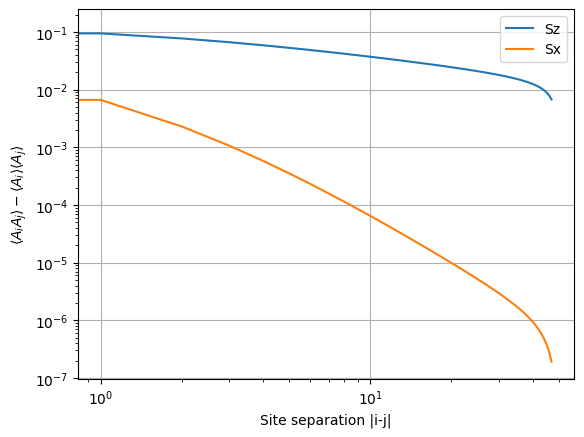

In [68]:
plt.plot(np.array([Sz_corr[0,i]-Sz_exp[0]*Sz_exp[i] for i in range(1,len(Sz_exp)-1)]),label='Sz')
plt.plot(np.array([Sx_corr[0,i]-Sx_exp[0]*Sx_exp[i] for i in range(1,len(Sx_exp)-1)]),label='Sx')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Site separation |i-j|')
plt.ylabel(r'$\langle A_i A_j\rangle-\langle A_i\rangle\langle A_j\rangle$')
plt.legend()
plt.grid()

On the other hand, if we are away from critical point, e.g. $J=g=1$, the correlation length decay exponentially

In [69]:
model, info = run(TFIsing_Coupling,dict(L=50,J=1,g=-1,S=1/2))

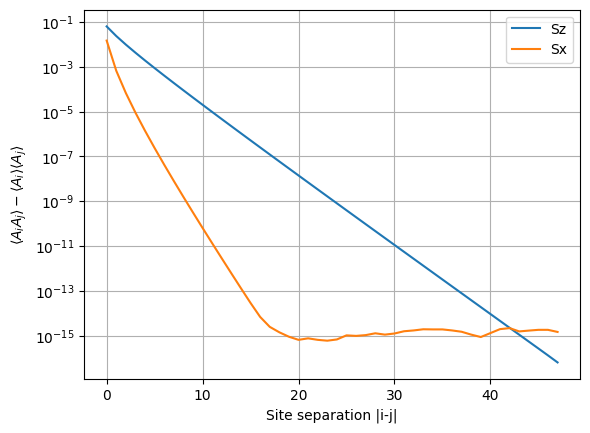

In [70]:
Sz_exp = info['psi'].expectation_value('Sz')
Sx_exp = info['psi'].expectation_value('Sx')
Sz_corr = info['psi'].correlation_function('Sz','Sz') # Correlation function
Sx_corr = info['psi'].correlation_function('Sx','Sx')
plt.plot(np.array([Sz_corr[0,i]-Sz_exp[0]*Sz_exp[i] for i in range(1,len(Sz_exp)-1)]),label='Sz')
plt.plot(np.array([Sx_corr[0,i]-Sx_exp[0]*Sx_exp[i] for i in range(1,len(Sx_exp)-1)]),label='Sx')
plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Site separation |i-j|')
plt.ylabel(r'$\langle A_i A_j\rangle-\langle A_i\rangle\langle A_j\rangle$')
plt.legend()
plt.grid()